# Detección de anomalías en un marco de auditoría continua

## 9. Datos desbalanceados - Modelos no supervisados - PyCaret

### 9.1. Split del dataset

Split del dataset para reservar un conjunto de datos para validación posterior al entrenamiento y desarrollo de los modelos.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import time
import joblib

# ! pip install pandas
# ! pip install numpy
# ! pip install pycaret==2.3.5
# ! pip install scipy==1.4.1
# ! pip install joblib
# ! pip install sklearn
# ! pip install hyperopt

In [2]:
# Filtro de warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga del dataset.
os.chdir('..')
df = pd.read_csv('df_preprocessed.csv')
df.head()

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
0,1,1,9839.64,0,170136.0,160296.36,6353307,0.0,0.0,0,0,0,1,0,0,0
1,1,1,1864.28,1,21249.0,19384.72,6353308,0.0,0.0,0,0,0,1,0,0,0
2,1,1,181.00,2,181.0,0.00,6353309,0.0,0.0,0,0,0,0,1,1,0
3,1,1,181.00,3,181.0,0.00,6353310,21182.0,0.0,0,1,0,0,0,1,0
4,1,1,11668.14,4,41554.0,29885.86,6353311,0.0,0.0,0,0,0,1,0,0,0


In [4]:
# Split del dataset para reservar un conjunto de validación.
from sklearn.model_selection import train_test_split
df_training, df_validation = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = np.array(df['isFraud']))

In [5]:
# Control de frecuencias de clases.
print('Proporcion de clases para dataset de training: %.4f' % (df_training['isFraud'].value_counts()[1] / df_training['isFraud'].value_counts()[0]))
print('Proporcion de clases para dataset de validación: %.4f' % (df_validation['isFraud'].value_counts()[1] / df_validation['isFraud'].value_counts()[0]))

Proporcion de clases para dataset de training: 0.0013
Proporcion de clases para dataset de validación: 0.0013


### 9.2. Detección de anomalías utilizando la librería PyCaret

https://towardsdatascience.com/unsupervised-anomaly-detection-in-python-f2e61be17c2b

https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html

https://pycaret.org/

In [7]:
# Importación de librerías.
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from hyperopt import fmin, hp, tpe, space_eval, Trials
from pycaret.anomaly import *

# Definición de la función objetivo.
def objective_func(search_space):

    global counter, scorings, df_subset
    
    start_time = time.time()
    counter += 1    
      
    kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    
    scores = {'accuracy' : [],
              'recall' : [],
              'precision' : [],
              'f1_score' : [],
              'roc_auc' : []
             }
    
    scorings_trial = {}

    for train, test in kfold.split(df_subset, y = df_subset.iloc[:, -2]):

        anom = setup(data = df_subset.iloc[train, :],
                     ignore_features = ['isFraud', 'isFlaggedFraud'], 
                     categorical_features = ['Cash_in', 'Cash_out', 'Debit', 'Payment', 'Transfer'],
                     normalize = True,
                     normalize_method = search_space['scaler'],
                     silent = True,
                     use_gpu = True,
                     verbose = False,
                     session_id = 42, 
                    )
        
        iforest = create_model(model = search_space['model'], fraction = search_space['fraction'], verbose = False)
        
        predictions = predict_model(iforest, data = df_subset.iloc[test, :])
        
        y_true = df_subset.iloc[test, -2]
        y_pred = predictions.loc[:, 'Anomaly']
        
        scores['accuracy'].append(accuracy_score(y_true = y_true, y_pred = y_pred))
        scores['recall'].append(recall_score(y_true = y_true, y_pred = y_pred))
        scores['precision'].append(precision_score(y_true = y_true, y_pred = y_pred))
        scores['f1_score'].append(f1_score(y_true = y_true, y_pred = y_pred))
        scores['roc_auc'].append(roc_auc_score(y_true = y_true, y_score = y_pred))
    
    scorings_trial['trial'] = counter
    scorings_trial['search_space'] = str(search_space)

    for score in scores:
        scorings_trial[score + '_mean'] = np.mean(scores[score])
        scorings_trial[score + '_std'] = np.std(scores[score])

    loss = 1 - scorings_trial['f1_score_mean'] + scorings_trial['f1_score_std']

    scorings.append(scorings_trial)
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds | Model: %s' % (counter, loss, elapsed_time, search_space['model']))

    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring, ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [9]:
# Importación de librerías.
from sklearn.model_selection import StratifiedShuffleSplit

# Espacio de búsqueda.
sss = StratifiedShuffleSplit(n_splits = 1, random_state = 42, train_size = 0.01)
for a, b in sss.split(df_training, df_training.iloc[:, -2]):
    df_subset = df_training.iloc[a, :]
scaler = ['zscore', 'minmax', 'maxabs', 'robust']
models = ['cluster', 'iforest', 'histogram', 'knn', 'lof', 'pca', 'mcd'] # abod, svm, cof, sos
search_space = {'scaler' : hp.choice('scaler', scaler),
                'model' : hp.choice('model', models),
                'fraction' : hp.randint('fraction', 1 , 50) / 100
               }

# Ejecución del optimizador.
counter = -1
scorings = []
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate = rstate)

Trial: 0 | Loss: 0.9936 | Elapsed_time: 6.9283 seconds | Model: pca
Trial: 1 | Loss: 0.9896 | Elapsed_time: 6.4910 seconds | Model: histogram        
Trial: 2 | Loss: 0.9863 | Elapsed_time: 23.6950 seconds | Model: iforest         
Trial: 3 | Loss: 0.9871 | Elapsed_time: 7.0536 seconds | Model: histogram        
Trial: 4 | Loss: 0.9917 | Elapsed_time: 31.9851 seconds | Model: knn             
Trial: 5 | Loss: 0.9903 | Elapsed_time: 6.4406 seconds | Model: pca              
Trial: 6 | Loss: 0.9752 | Elapsed_time: 25.6134 seconds | Model: lof             
Trial: 7 | Loss: 0.9951 | Elapsed_time: 9.3292 seconds | Model: cluster          
Trial: 8 | Loss: 0.9896 | Elapsed_time: 6.5088 seconds | Model: pca              
Trial: 9 | Loss: 0.9921 | Elapsed_time: 6.4320 seconds | Model: histogram        
Trial: 10 | Loss: 0.9929 | Elapsed_time: 10.8509 seconds | Model: cluster         
Trial: 11 | Loss: 0.9855 | Elapsed_time: 6.5266 seconds | Model: pca              
Trial: 12 | Loss: 0.9875 | E

In [10]:
# Importación de librerías.
import os
import json
from datetime import datetime

hyperopt_printer(trials)
json_export(scorings)
scorings_df = scorings_to_df(scorings)


Best Trial:
Trial ID : 35
Loss : 0.9586407181073524
Params : {'fraction': 0.02, 'model': 'histogram', 'scaler': 'robust'}

Json file: 20220515_194832.json

Scoring details:

   trial                                       search_space accuracy_mean accuracy_std recall_mean recall_std precision_mean precision_std f1_score_mean f1_score_std roc_auc_mean roc_auc_std
0      0  {'fraction': 0.32, 'model': 'pca', 'scaler': '...      0.680864     0.004872    0.877757   0.074414       0.003557      0.000335      0.007085     0.000667     0.779182    0.036328
1      1  {'fraction': 0.17, 'model': 'histogram', 'scal...      0.831139     0.004583    0.786765   0.090951       0.006024      0.000783      0.011956     0.001553      0.80898    0.045656
2      2  {'fraction': 0.15, 'model': 'iforest', 'scaler...      0.850963     0.004399    0.832721   0.029007       0.007204       0.00029      0.014285     0.000574     0.841853     0.01346
3      3  {'fraction': 0.07, 'model': 'histogram', 'scal...  

### 9.3. Evaluación sobre el conjunto de validación

Best Trial:
Trial ID : 35
Loss : 0.9586407181073524
Params : {'fraction': 0.02, 'model': 'histogram', 'scaler': 'robust'}

In [16]:
%%time
# Evaluación con el conjunto de validación.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from pycaret.anomaly import *
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df_training_preprocessed = df_training
train_index = df_training_preprocessed.index
train_columns = df_training_preprocessed.columns
df_training_preprocessed = pd.DataFrame(scaler.fit_transform(df_training_preprocessed))
df_training_preprocessed.index = train_index
df_training_preprocessed.columns = train_columns

anom = setup(data = df_training_preprocessed,
             ignore_features = ['isFraud', 'isFlaggedFraud'], 
             categorical_features = ['Cash_in', 'Cash_out', 'Debit', 'Payment', 'Transfer'],
             silent = True,
             use_gpu = True,
             verbose = True,
             session_id = 42,
             n_jobs = -1,
             preprocess = False
            )

,Description,Value
0,session_id,42
1,Original Data,"(5090096, 16)"
2,Missing Values,False
3,Numeric Features,9
4,Categorical Features,5
5,Transformed Data,"(5090096, 14)"
6,CPU Jobs,-1
7,Use GPU,True
8,Log Experiment,False
9,Experiment Name,anomaly-default-name


CPU times: total: 2min 29s
Wall time: 2min 34s


In [17]:
# Entrenamiento del modelo.
model = create_model(model = 'histogram', fraction = 0.02, verbose = True)

In [18]:
# Aplicación sobre el conjunto de validación.
df_validation_preprocessed = df_validation
validation_index = df_validation_preprocessed.index
validation_columns = df_validation_preprocessed.columns
df_validation_preprocessed = pd.DataFrame(scaler.fit_transform(df_validation_preprocessed))
df_validation_preprocessed.index = validation_index
df_validation_preprocessed.columns = validation_columns

predictions = predict_model(model, data = df_validation_preprocessed)

In [19]:
# Obtención de metricas.
y_test = df_validation.iloc[:, -2]
y_pred = predictions.loc[:, 'Anomaly']

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.2678
Precision: 0.0135
AUC: 0.6213
Accuracy: 0.9739
F1-Score: 0.0258


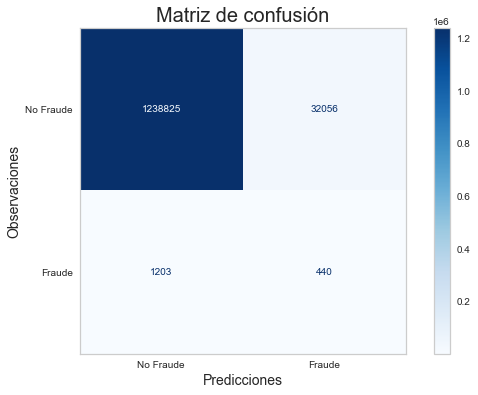

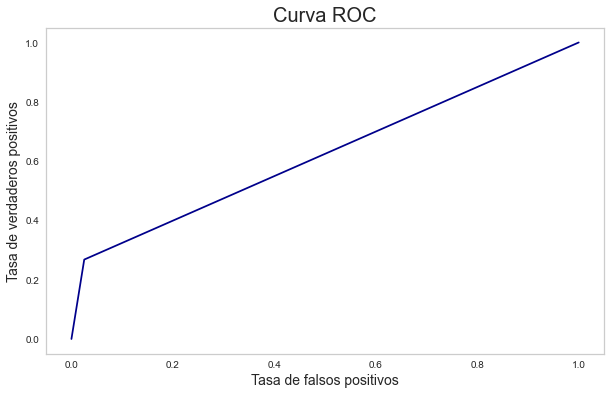

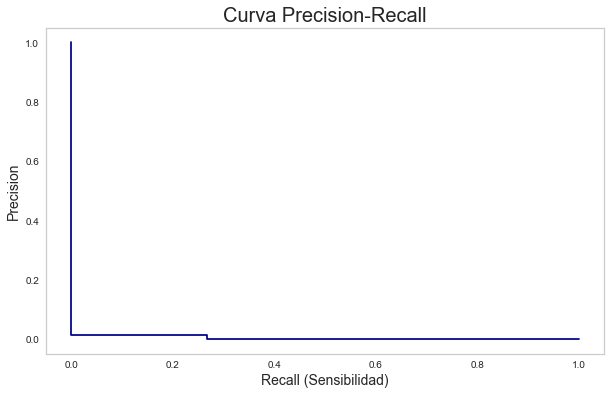

In [20]:
# Exportación a png.
from export import export_png_2
export_png_2(filename = 'pycaret', y_test = y_test, y_pred = y_pred)

In [26]:
%%time
# Exportación a csv.
y_test.to_csv('pycaret_ytest_unbalanced.csv')
y_pred.to_csv('pycaret_ypred_unbalanced.csv')

CPU times: total: 7.17 s
Wall time: 7.32 s
